In [1]:
%pip install -Uq fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.5 MB/s eta 0:00:00


In [2]:
from fastai.vision.all import *
from fastai.data.external import untar_data, URLs

In [3]:
# Get data
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/images')]

## **Vision Segmentation:**

In [4]:
# Get data
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/images')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

(#3) [Path('/root/.fastai/data/camvid_tiny/images/0001TP_008400.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_01260.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_07997.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('/root/.fastai/data/camvid_tiny/labels/0006R0_f02610_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f00210_P.png'),Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f02640_P.png')]

In [9]:
# Load and prepare data
def get_y_fn(x):
    return Path(str(x).replace('images', 'labels').replace('.png', '_P.png'))

In [10]:
# Create datablock
codes = np.loadtxt(path/'codes.txt', dtype=str)

segmentation = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                         get_items=get_image_files,
                         splitter=RandomSplitter(),
                         get_y=get_y_fn,
                         item_tfms=Resize(128),
                         batch_tfms=aug_transforms())
dls = segmentation.dataloaders(path/"images")

In [11]:
# Define the model
learn = unet_learner(dls, resnet34, metrics=Dice)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 70.9MB/s]


In [12]:
# Train the model
learn.fine_tune(2)

epoch,train_loss,valid_loss,dice,time
0,3.480367,3.262508,16.273397,01:43


epoch,train_loss,valid_loss,dice,time
0,3.243357,5.121135,17.490401,01:42
1,3.543860,2.870511,16.867494,01:41


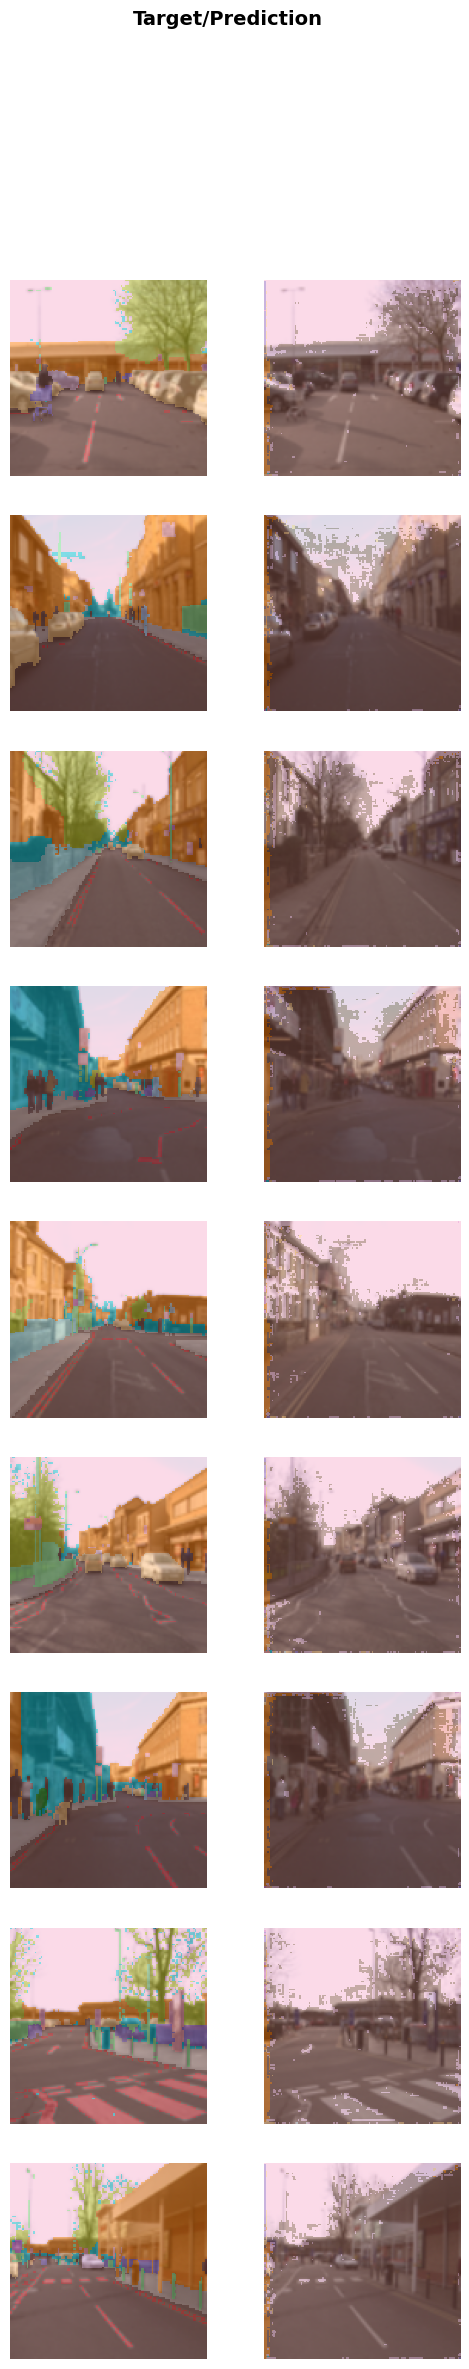

In [13]:
# Display results
learn.show_results()

## **Tabular Task:**

In [14]:
from fastai.tabular.all import *

In [15]:
# Load and prepare data
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

SuggestedLRs(valley=0.00363078061491251)

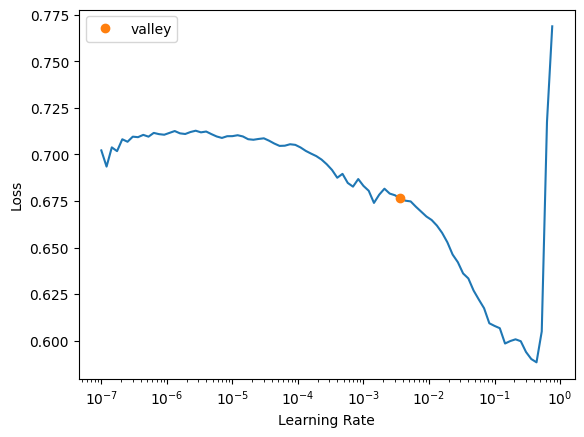

In [16]:
# Find the learning optimal learning rate
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find()

In [17]:
# Train the model based on suggested learning rate
learn.fit_one_cycle(3, 0.0025)

epoch,train_loss,valid_loss,accuracy,time
0,0.379824,0.363507,0.832002,00:17
1,0.358463,0.358287,0.833845,00:08
2,0.349299,0.352052,0.839988,00:07


In [18]:
import pandas as pd

# Load the Adult dataset into a DataFrame
df = pd.read_csv(path/'adult.csv')

# Make a prediction on the first instance in the dataset
row, clas, probs = learn.predict(df.iloc[0])

In [19]:
learn.show_results()
loss, accuracy = learn.validate()
print(f'Accuracy: {accuracy*100}%')

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,12.0,3.0,8.0,1.0,5.0,1.0,-1.069151,-0.097687,-0.426388,0.0,0.0
1,3.0,13.0,3.0,5.0,1.0,5.0,1.0,0.770470,-1.441144,1.539242,1.0,1.0
2,5.0,12.0,3.0,2.0,1.0,5.0,1.0,0.844054,-0.850293,-0.426388,0.0,0.0
3,7.0,13.0,3.0,5.0,1.0,5.0,1.0,0.108206,0.134680,1.539242,1.0,1.0
4,5.0,12.0,1.0,8.0,2.0,5.0,1.0,-0.112548,0.956349,-0.426388,0.0,0.0
5,3.0,16.0,1.0,2.0,5.0,5.0,1.0,-0.112548,-0.584678,-0.033262,0.0,0.0
6,5.0,12.0,3.0,4.0,1.0,5.0,1.0,0.844054,0.361334,-0.426388,1.0,0.0
7,5.0,16.0,3.0,4.0,1.0,5.0,1.0,-0.701227,0.323345,-0.033262,1.0,0.0
8,5.0,16.0,3.0,2.0,6.0,5.0,1.0,0.108206,0.033661,-0.033262,0.0,1.0


Accuracy: 83.99876952171326%


## **Recommendation Task:**

In [20]:
from fastai.collab import *

In [21]:
# Load and prepare data
path = untar_data(URLs.ML_SAMPLE)
data = pd.read_csv(path/'ratings.csv')

In [22]:
print(data.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [23]:
# Create a collab_learner
dls = CollabDataLoaders.from_df(data, item_name='movieId', bs=64)
learn = collab_learner(dls, y_range=(0.5,5.5))

SuggestedLRs(valley=0.0030199517495930195)

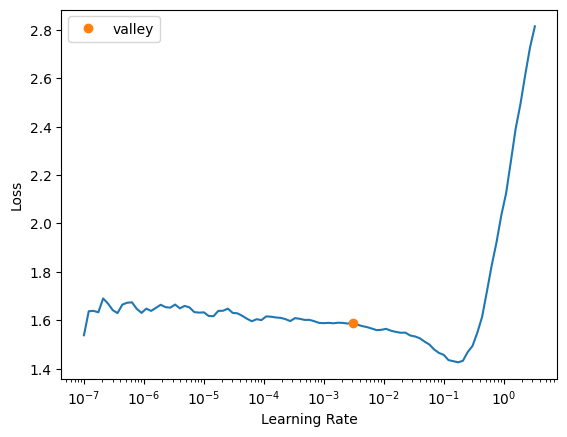

In [24]:
# Get the optimal learning rate
learn.lr_find()

In [25]:
# Train the model
learn.fit_one_cycle(3, 3e-5)

epoch,train_loss,valid_loss,time
0,1.616892,1.481495,00:00
1,1.594580,1.478287,00:00
2,1.582134,1.477630,00:00


In [26]:
# Get the model's predictions and targets
preds, targets = learn.get_preds()

# Calculate the mean squared error
mse = ((preds - targets)**2).mean()

# Print the MSE
print(f'Mean Squared Error: {mse.item()}')

Mean Squared Error: 1.4792968034744263


In [27]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,10.0,53.0,3.0,2.988815
1,20.0,28.0,1.5,3.009774
2,72.0,86.0,3.0,3.036623
3,64.0,21.0,5.0,2.983538
4,35.0,16.0,4.0,2.988852
5,98.0,16.0,5.0,2.993418
6,20.0,30.0,1.5,3.015264
7,83.0,66.0,4.5,3.005374
8,37.0,35.0,3.0,2.999506
